# Chatbot with sequence to sequence model

We implement a simple chatbot using the sequence to sequence model developed by Ilya Sutskever, Oriol Vinyals and Quoc V. Le (https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf) which uses two LSTM neural networks, one for encodeing purpose and one for decoding purpose.
We train the model on the famous Cornell movie-dialogs corpus (https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html).

Notice that we considered dialogs as couples of sentences, of which the first sentence is denote as "question" (althogh it is not always a question grammatically) and the second one as "answer"

In [235]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping
import numpy as np
import io
import pandas as pd
import ast
import matplotlib.pyplot as plt

## Part 1: Get question and answers from dataset and clean them

We start from a list (containing lists of dialogs) and from a dictionary (with keys corresponding to the identification codes of dialogs and values corresponding to dialogs). From them we get a list of questions and a list of answers. 

In [171]:
lin=io.open('cornell/movie_lines.txt',encoding="utf-8",errors="ignore").read().split('\n')
conv=io.open('cornell/movie_conversations.txt',encoding="utf-8",errors="ignore").read().split('\n')

In [172]:
print lin[:10]
print conv[:10]

[u'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!', u'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!', u'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.', u'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?', u"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.", u'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow', u"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.", u'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No', u'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?', u'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?']
[u"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']", u"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']", u"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']", u"u0 +++$++

In [173]:
conversations=[]
for co in conv:
    conversations.append(co.split(" +++$+++ ")[-1])

conversations=[str(x) for x in conversations]
conversations=[ast.literal_eval(x) for x in conversations[:-1]]

In [174]:
conversations

[['L194', 'L195', 'L196', 'L197'],
 ['L198', 'L199'],
 ['L200', 'L201', 'L202', 'L203'],
 ['L204', 'L205', 'L206'],
 ['L207', 'L208'],
 ['L271', 'L272', 'L273', 'L274', 'L275'],
 ['L276', 'L277'],
 ['L280', 'L281'],
 ['L363', 'L364'],
 ['L365', 'L366'],
 ['L367', 'L368'],
 ['L401', 'L402', 'L403'],
 ['L404', 'L405', 'L406', 'L407'],
 ['L575', 'L576'],
 ['L577', 'L578'],
 ['L662', 'L663'],
 ['L693', 'L694', 'L695'],
 ['L696', 'L697', 'L698', 'L699'],
 ['L860', 'L861'],
 ['L862', 'L863', 'L864', 'L865'],
 ['L866', 'L867', 'L868', 'L869'],
 ['L870', 'L871', 'L872'],
 ['L924', 'L925'],
 ['L984', 'L985'],
 ['L1044', 'L1045'],
 ['L49', 'L50', 'L51'],
 ['L571', 'L572', 'L573'],
 ['L579', 'L580'],
 ['L595', 'L596', 'L597'],
 ['L598', 'L599', 'L600'],
 ['L659', 'L660'],
 ['L952', 'L953'],
 ['L394', 'L395'],
 ['L396', 'L397'],
 ['L589', 'L590', 'L591'],
 ['L592', 'L593'],
 ['L756', 'L757', 'L758'],
 ['L759', 'L760'],
 ['L164', 'L165'],
 ['L319', 'L320'],
 ['L441', 'L442', 'L443', 'L444', 'L445']

In [175]:
lines=[]
for li in lin:
    lines.append([str(li.split(" +++$+++ ")[0]),str(li.split(" +++$+++ ")[-1])])
lines=lines[:-1]

lines_dict={}
for line in lines:
    lines_dict[line[0]]=line[1]

In [176]:
lines_dict

{'L479748': 'And what did you say?',
 'L638646': 'Oh, yes. You noticed the way she does her hair.',
 'L525290': 'Cool!',
 'L638647': 'Something else. My wife, Madeleine, has several pieces of jewelry that belonged to Carlotta. She inherited them. Never wore them, they were too old-fashioned... until now. Now, when she is alone, she gets them out and looks at them handles them gently, curiously... puts them on and stares at herself in the mirror... and goes into that other world... is someone else again.',
 'L345355': 'For what? Breaking my heart or ruining sex for me with any other man?',
 'L345354': "I'm sorry?",
 'L345357': "Forget it. I've already spent too many hours crying over you.",
 'L345356': 'Uh -- both?',
 'L345351': 'What?',
 'L345350': "Why didn't you call me?",
 'L345353': '-- uh --',
 'L345352': 'We spend a beautiful night together and then I never hear from you again?',
 'L28088': "It won't play.",
 'L568037': "David. David Wills. I'm your liaison officer with the Allie

In [177]:
questions=[]
answers=[]
for conv in conversations:
    for ind in range(len(conv)-1):
        questions.append(lines_dict[conv[ind]])
        answers.append(lines_dict[conv[ind+1]])

In [178]:
# We check that questions and answers have the same length

print len(questions),len(answers)

221616 221616


In [179]:
# Do questions and answers make sense? It seems so.

for i in range(5):
    print questions[i]
    print answers[i],"\n"

Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you. 

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please. 

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night? 

You're asking me out.  That's so cute. What's your name again?
Forget it. 

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron. 



### Part 1.1: Clean questions and answers

Before feeding them to the chatbot, we need to clean questions and answers and select only the ones of "medium" length

In [180]:
qa=pd.DataFrame({"question":questions,"answer":answers})

In [181]:
def clean(text):
    
    text=text.lower()
    
    text=text.replace("'m"," am")
    text=text.replace("'re"," are")
    text=text.replace("he's","he is")
    text=text.replace("she's","she is")
    text=text.replace("that's","that is")
    text=text.replace("how's","how is")
    text=text.replace("'ll"," will")
    text=text.replace("'d"," would")
    text=text.replace("won't","will not")
    text=text.replace("can't","can not")
    text=text.replace("'till","untill")
    text=text.replace("where's","where is")
    text=text.replace("n't"," not")
    text=text.replace("'till","untill")
    text=text.replace("n'","ng")
    
    for item in ["@","#","!",":","?","(",")","<",">","-","[","]","'","_",",","'","*",".","^","=",";",'"']:
        text=text.replace(item,"")
    
    return text

In [182]:
qa["question"]=qa["question"].apply(clean)
qa["answer"]=qa["answer"].apply(clean)

qa["question"]=qa["question"].apply(lambda x:x.split())
qa["answer"]=qa["answer"].apply(lambda x:x.split())

qa["question_len"]=qa["question"].apply(lambda x:len(x))
qa["answer_len"]=qa["answer"].apply(lambda x:len(x))

In [183]:
qa.iloc[:10,:]

,answer,question,question_len,answer_len
0,"[well, i, thought, we, would, start, with, pro...","[can, we, make, this, quick, roxanne, korrine,...",22,14
1,"[not, the, hacking, and, gagging, and, spittin...","[well, i, thought, we, would, start, with, pro...",14,9
2,"[okay, then, how, bout, we, try, out, some, fr...","[not, the, hacking, and, gagging, and, spittin...",9,12
3,"[forget, it]","[you, are, asking, me, out, that, is, so, cute...",13,2
4,[cameron],"[no, no, its, my, fault, we, did, not, have, a...",12,1
5,"[the, thing, is, cameron, i, am, at, the, merc...",[cameron],1,25
6,"[seems, like, she, could, get, a, date, easy, ...","[the, thing, is, cameron, i, am, at, the, merc...",25,9
7,"[unsolved, mystery, she, used, to, be, really,...",[why],1,25
8,"[that, is, a, shame]","[unsolved, mystery, she, used, to, be, really,...",25,4
9,"[let, me, see, what, i, can, do]","[gosh, if, only, we, could, find, kat, a, boyf...",9,7


In [184]:
min_len=3
max_len=9

qas=qa.drop(qa.index[(qa.question_len>max_len)|(qa.question_len<min_len)],axis=0)
qas=qas.drop(qas.index[(qas.answer_len>max_len)|(qas.answer_len<min_len)],axis=0)

In [185]:
qas.iloc[:10,:]

,answer,question,question_len,answer_len
9,"[let, me, see, what, i, can, do]","[gosh, if, only, we, could, find, kat, a, boyf...",9,7
10,"[right, see, you, are, ready, for, the, quiz]","[cesc, ma, tete, this, is, my, head]",7,8
17,"[you, are, sweet]","[you, have, my, word, as, a, gentleman]",7,3
25,"[i, believe, we, share, an, art, instructor]","[you, know, chastity]",3,7
37,"[the, real, you]","[what, good, stuff]",3,3
38,"[like, my, fear, of, wearing, pastels]","[the, real, you]",3,6
43,"[they, do, not]","[they, do, to]",3,3
53,"[i, do, not, have, to, be, home, til, two]","[i, have, to, be, home, in, twenty, minutes]",8,9
63,"[nowhere, hi, daddy]","[whereve, you, been]",3,3
74,"[can, we, go, now]","[you, are, so, completely, unbalanced]",5,4


## Part 1.2: Select only questions and answers with frequent words

In order to make training easier, we select only questions and answers with frequent words

In [186]:
# voc_freq_q contains each word which appears in questions with its number of occurences

voc_freq_q={}

for sent in list(qas["question"]):
    for word in sent:
        if word not in voc_freq_q.keys():
            voc_freq_q[word]=1
        else:
            voc_freq_q[word]+=1

In [187]:
# voc_freq_a contains each word which appears in answers with its number of occurences

voc_freq_a={}

for sent in list(qas["answer"]):
    for word in sent:
        if word not in voc_freq_a.keys():
            voc_freq_a[word]=1
        else:
            voc_freq_a[word]+=1

In [188]:
print len(voc_freq_q.keys()),len(voc_freq_a.keys())

16153 16099


In [189]:
# Now we select only the words which appear at least *limit* number of times

limit = 40
freq_words_q=[]
for word,freq in voc_freq_q.items():
    if freq>limit:
        freq_words_q.append(word)
        
freq_words_a=[]
for word,freq in voc_freq_a.items():
    if freq>limit:
        freq_words_a.append(word)

In [190]:
# See that they are much fewer

print len(freq_words_q),len(freq_words_a)

569 562


In [191]:
# Replace each non-frequent word in questions with "UNK" and remove from the dataframe questions with "UNK"

for sent in qas["question"]:
    for ind in range(len(sent)):
        if sent[ind] not in freq_words_q:
            sent[ind]="UNK"
            
qas["clean_question_len"]=qas["question"].apply(lambda x : len([ele for ele in x if ele!="UNK"]))
qas=qas.drop(qas.index[qas["question_len"]-qas["clean_question_len"]>0],axis=0)

In [192]:
# Do the same for answers

for sent in qas["answer"]:
    for ind in range(len(sent)):
        if sent[ind] not in freq_words_a:
            sent[ind]="UNK"

qas["clean_answer_len"]=qas["answer"].apply(lambda x : len([ele for ele in x if ele!="UNK"]))
qas=qas.drop(qas.index[qas["answer_len"]-qas["clean_answer_len"]>0],axis=0)

In [193]:
# The answers must start with "ST" (which signals to the model that the answer is starting) and end with "EOS" 
# (which signals to the model that the answer is ending)

qas["answer"]=qas["answer"].apply(lambda x : ["ST"]+x+["EOS"])

In [194]:
qas.iloc[:10,:]

,answer,question,question_len,answer_len,clean_question_len,clean_answer_len
37,"[ST, the, real, you, EOS]","[what, good, stuff]",3,3,3,3
43,"[ST, they, do, not, EOS]","[they, do, to]",3,3,3,3
100,"[ST, i, just, wanted, EOS]","[you, set, me, up]",4,3,4,3
132,"[ST, so, they, tell, me, EOS]","[you, the, new, guy]",4,4,4,4
158,"[ST, you, wanna, go, out, with, him, EOS]","[what, about, him]",3,6,3,6
175,"[ST, okay, i, was, not, sure, EOS]","[he, is, pretty]",3,5,3,5
197,"[ST, not, at, all, EOS]","[hey, do, you, mind]",4,3,4,3
200,"[ST, and, why, would, i, do, that, EOS]","[leave, my, sister, alone]",4,6,4,6
205,"[ST, you, need, money, to, take, a, girl, out,...","[you, just, said]",3,8,3,8
286,"[ST, funny, you, are, the, only, one, EOS]","[i, say, do, what, you, wanna, do]",7,6,7,6


## Part 1.3: Tokenize questions and answers

The model will read questions and answers in tokenized form. In order to tokenize questions and answers we first need to get the four dictionaries word_to_num_q, num_to_word_q,word_to_num_a and num_to_word_a.

In [195]:
word_to_num_q={}
num_to_word_q={}

for num,word in enumerate(freq_words_q):
    word_to_num_q[word]=num
    num_to_word_q[num]=word

In [196]:
print word_to_num_q["have"]
print num_to_word_q[409]

409
have


In [197]:
freq_words_a=freq_words_a+["ST"]+["EOS"]

word_to_num_a={}
num_to_word_a={}
for num,word in enumerate(freq_words_a):
    word_to_num_a[word]=num
    num_to_word_a[num]=word

In [198]:
print word_to_num_a["have"]
print num_to_word_a[404]

404
have


In [199]:
max_len_q=qas.question.apply(lambda x : len(x)).max()
max_len_a=qas.answer.apply(lambda x : len(x)).max()
print max_len_q,max_len_a

9 11


In [200]:
# It will be clear in the following why target is equal to token_a shifted by 1

token_q=np.zeros(shape=(qas.shape[0],max_len_q,len(freq_words_q)))
token_a=np.zeros(shape=(qas.shape[0],max_len_a,len(freq_words_a)))
target=np.zeros(shape=(qas.shape[0],max_len_a,len(freq_words_a)))

In [201]:
print token_q.shape,token_a.shape,target.shape

(9008, 9, 569) (9008, 11, 564) (9008, 11, 564)


In [202]:
for i,ind in enumerate(qas.index):
    for j,word in enumerate(qas["question"][ind]):
        token_q[i,j,word_to_num_q[word]]=1
        
    for j,word in enumerate(qas["answer"][ind]):
        token_a[i,j,word_to_num_a[word]]=1
        if j>0:
            target[i,j-1,word_to_num_a[word]]=1

# Part 2: Define the model

The model consists of two recurrent LSTM neural networks, one for encoder and one for decoder purpose.

The encoder neural network reads each question and then transmits to the decoder neural network only the final hidden and internal states (indeed it has return_state=True and return_sequences=False).

The decoder neural network, given each answer, starts with the states received from the encoder and then predicts the answer one word at a time: for each entry of token_a it predicts the corresponding entry of target, which is shifted by 1.

Notice that we need to define two models, one for training and one for testing (but they share the same weights): this is because during testing the model predicts the answer one word at a time considering the words (and corresponding states) it predicted so far.

In [233]:
# Training models

# Encoder model 

encoder_input=Input(shape=(None,len(freq_words_q))) 
encoder_LSTM=LSTM(1024,return_state=True)
encoder_outputs,encoder_h,encoder_c=encoder_LSTM(encoder_input)
encoder_states=[encoder_h,encoder_c]


# Decoder model

decoder_input=Input(shape=(None,len(freq_words_a))) 
decoder_LSTM=LSTM(1024,return_state=True,return_sequences=True)
decoder_output,_,_=decoder_LSTM(decoder_input,initial_state=encoder_states)
decoder_dense=Dense(len(freq_words_a),activation="softmax")
decoder_out=decoder_dense(decoder_output)

In [234]:
es=EarlyStopping(monitor="val_loss",patience=5,verbose=1)
model=Model(inputs=[encoder_input,decoder_input],outputs=[decoder_out])

model.compile(optimizer="rmsprop",loss="categorical_crossentropy")
history=model.fit(x=[token_q,token_a],y=target,batch_size=128,callbacks=[es],epochs=40,validation_split=0.2)

Train on 7206 samples, validate on 1802 samples
Epoch 1/40
7206/7206 [==============================] - 191s 27ms/step - loss: 2.5576 - val_loss: 2.4382
Epoch 2/40
7206/7206 [==============================] - 178s 25ms/step - loss: 2.3657 - val_loss: 2.3967
Epoch 3/40
7206/7206 [==============================] - 177s 25ms/step - loss: 2.2473 - val_loss: 2.2449
Epoch 4/40
7206/7206 [==============================] - 176s 24ms/step - loss: 2.1049 - val_loss: 2.1509
Epoch 5/40
7206/7206 [==============================] - 180s 25ms/step - loss: 1.9951 - val_loss: 2.0833
Epoch 6/40
7206/7206 [==============================] - 177s 25ms/step - loss: 1.9082 - val_loss: 2.0092
Epoch 7/40
7206/7206 [==============================] - 695s 96ms/step - loss: 1.8402 - val_loss: 1.9642
Epoch 8/40
7206/7206 [==============================] - 172s 24ms/step - loss: 1.7741 - val_loss: 1.9602
Epoch 9/40
7206/7206 [==============================] - 174s 24ms/step - loss: 1.7137 - val_loss: 1.9511
Epoch 1

NameError: name 'plt' is not defined

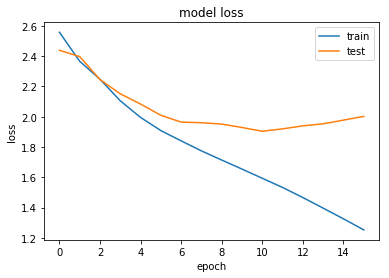

In [236]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [237]:
model.save_weights('model_weights.h5')

## Part 2.1: Define the testing (inference) model and get answers from chatbot

In [238]:
# Testing (inference) models

inf_encoder_model=Model(encoder_input,encoder_states)

decoder_input_states=[Input(shape=(1024,)),Input(shape=(1024,))]
decoder_output,decoder_h,decoder_c=decoder_LSTM(decoder_input,initial_state=decoder_input_states)
decoder_states=[decoder_h,decoder_c]
decoder_output=decoder_dense(decoder_output)
inf_decoder_model=Model(inputs=[decoder_input]+decoder_input_states,outputs=[decoder_output]+decoder_states)

In [239]:
def get_answer(token):
    
    states=inf_encoder_model.predict(token)
    target=np.zeros(shape=(1,1,len(freq_words_a)))
    target[0,0,word_to_num_a["ST"]]=1
    answer=[]
    proceed=True
    
    while proceed:
        decoder_out,decoder_h,decoder_c=inf_decoder_model.predict(x=[target]+states)
        new_word=num_to_word_a[np.argmax(decoder_out[0,-1,:])]
        answer.append(new_word)
        if (new_word=="EOS") or (len(answer)==max_len_a):
            proceed=False
        
        states=[decoder_h,decoder_c]
        target=np.zeros(shape=(1,1,len(freq_words_a)))
        target[0,0,word_to_num_a[new_word]]=1
    return answer

In [240]:
def tokenize(sent):
    token=np.zeros(shape=(1,max_len_q,len(freq_words_q)))
    for ind,word in enumerate(sent):
        token[0,ind,word_to_num_q[word]]=1
    return token

### Now we can talk with the chatbot, of course all words of our sentences will need to be in freq_words_q

In [259]:
questions=[["how","are","you"],["where","are","you","going"],["are","you","really","trying"],\
          ["i","have","good","luck","this","morning"]]

for question in questions:
    token=tokenize(question)
    answer=get_answer(token)
    
    print("Question: {}".format(question))
    print("Answer from chatbot: {}\n".format(answer))

Question: ['how', 'are', 'you']
Answer from chatbot: ['i', 'do', 'not', 'know', 'how', 'much', 'i', 'feel', 'EOS']

Question: ['where', 'are', 'you', 'going']
Answer from chatbot: ['i', 'am', 'going', 'to', 'you', 'you', 'EOS']

Question: ['are', 'you', 'really', 'trying']
Answer from chatbot: ['no', 'i', 'am', 'fine', 'EOS']

Question: ['i', 'have', 'good', 'luck', 'this', 'morning']
Answer from chatbot: ['i', 'love', 'you', 'EOS']

